# **REPRESENTACIÓN DE JUGADORES EN UN MINIMAPA DE LA PISTA**

En este notebook se presenta el módulo encargado de introducir una representación en forma de minimapa, donde las posiciones de los jugadores van a proyectarse en el plano mediante la homografía inversa de la calcula anteriormente en el notebook previo `TennisCourtDetection.ipynb`.


In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

!gdown --id 1lhAaeQCmk2y440PmagA0KmIVBIysVMwu -O tennis_court_det_dataset.zip

#!unzip drive/MyDrive/dataset_tennis/tennis_court_det_dataset.zip
#flag -q para no mostrar la salida
!unzip -q ./tennis_court_det_dataset.zip

Mounted at /content/drive
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1lhAaeQCmk2y440PmagA0KmIVBIysVMwu
From (redirected): https://drive.google.com/uc?id=1lhAaeQCmk2y440PmagA0KmIVBIysVMwu&confirm=t&uuid=32a87802-c670-456b-810c-2ab0b2aef045
To: /content/tennis_court_det_dataset.zip
100% 7.26G/7.26G [00:34<00:00, 208MB/s]


## **DATASET: TRACKNET**



Para facilitar el acceso al dataset, que se encuentra en la plataforma **Kaggle**, se establece el acceso a Google Drive, donde se va a guardar la **clave de autenticación de usuario** (`kaggle.json`) de dicha plataforma para poder descargarlo directamente desde sus servidores.




In [ ]:
!mkdir -p ~/.kaggle

!cp /content/drive/MyDrive/dataset_tennis/kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

print("¡Llave copiada con éxito!")
!ls -l ~/.kaggle
!kaggle datasets list | head

cp: cannot stat '/content/drive/MyDrive/dataset_tennis/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
¡Llave copiada con éxito!
total 0
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 4, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/


Finalmente, se descarga el dataset **TrackNet Tennis**, que contiene **secuencias de vídeo** de partidos de tenis junto con la estructura necesaria para tareas de detección y seguimiento. En concreto, es el conjunto de datos específico para **entrenamiento de modelos de ML y redes neuronales** para la detección y seguimiento de **pelotas de tenis**, pero, en nuestro caso, vamos a utilizarlo también para **validar nuestro trabajo**.  

In [ ]:
!kaggle datasets download -d sofuskonglevoll/tracknet-tennis -p data

Dataset URL: https://www.kaggle.com/datasets/sofuskonglevoll/tracknet-tennis
License(s): unknown
 99% 2.38G/2.39G [00:07<00:00, 341MB/s]
100% 2.39G/2.39G [00:07<00:00, 348MB/s]


In [ ]:
!mkdir -p data/tracknet
!unzip -q -o data/tracknet-tennis.zip -d data/tracknet

### **BIBLIOTECAS Y FUNCIONES/CLASES AUXILIARES**



In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/tenis_functions')

import cv2
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import glob


from court_functions import *
from player_map_functions import *
from detect_players_functions import *

In [ ]:
!pip install ultralytics
from ultralytics import YOLO

## **POSICIÓN DEL JUGADOR**

Una vez estimada la homografía que relaciona el modelo ideal de la pista con la imagen capturada por la cámara, es posible **invertir dicha transformación para realizar el proceso inverso**: **proyectar puntos detectados** en la imagen real al sistema de coordenadas de la pista. Esto se logra calculando la **homografía inversa**, que permite **pasar de coordenadas de imagen a coordenadas del plano** de la pista.

La función `h_inv()` calcula simplemente la **inversa de la matriz de homografía**. Desde el punto de vista geométrico, esta operación invierte la transformación proyectiva previamente estimada, de modo que **cualquier punto** localizado en la imagen, como la posición de un jugador o de la pelota, puede ser **mapeado a su posición correspondiente en el modelo de pista**.

Al aplicar la homografía inversa a las coordenadas de los jugadores detectados en la imagen, se obtiene su **localización en un plano cenital ideal** de la pista, que era el que usabamos para en un principio dibujar las lineas sobre los keypoints detectados.

Esto permite construir un **minimapa** o vista superior en la que las **posiciones pueden representarse de forma consistente** y comparable entre distintos fotogramas. Con esto podremos, a parte de visualizar las posiciones relativas de los jugadores en la pista en este fotograma, realizar **cálculos mas precisos respecto a sus posiciones como su velocidad o la distancia recorrida** de cada jugador, ya que tenemos su movimiento a escala real, ya no afectada por la perspectiva.

In [ ]:
# función que calcula la inversa de la homografía dada

def h_inv(H):
  return np.linalg.inv(H)

La función `image_to_court()` se encarga de **transformar un punto expresado en coordenadas** de la imagen al **sistema de coordenadas de la pista** utilizando la **homografía inversa** previamente calculada.

El punto de entrada se reorganiza al formato requerido por `cv2.perspectiveTransform`, que espera un **conjunto de puntos** con la forma $(N, 1, 2)$. Seguidamente, se aplica la transformación proyectiva definida por la matriz de homografía inversa y **devuelve la posición** correspondiente del **punto** en el plano de la pista. Finalmente, el resultado se vuelve a reestructurar a un vector bidimensional sencillo para facilitar su uso posterior.

In [ ]:
# función que convierte un punto detectado en la imagen (píxeles) a su posición equivalente
# sobre el plano de la pista aplicando la homografía inversa

def image_to_court(point_img, H_inv):
    pt = point_img.reshape(1, 1, 2)
    pt_court = cv2.perspectiveTransform(pt, H_inv)
    return pt_court.reshape(2)

Para **proyectar la posición de los jugadores** desde la imagen original **al minimapa de la pista**, se utiliza el **punto central del borde inferior** de la **bounding box** detectada. Este **punto** constituye una **aproximación fiable de la proyección del jugador** sobre el plano del suelo, ya que se encuentra próximo al contacto real con la superficie de la pista y, por tanto, al plano sobre el que se define la homografía.

Esta elección presenta además **ventajas prácticas** frente al uso de otros puntos, como el **punto medio entre ambos pies**. En escenarios reales de partido, los pies suelen estar parcial o totalmente ocluidos, en movimiento rápido o fuera del campo de visión, lo que dificulta su detección consistente por parte de modelos como YOLO. En cambio, el **borde inferior** de la **bounding box** es una característica **más estable y robusta**, lo que permite **estimar de forma más consistente la posición** del jugador en el **plano de la pista** a lo largo del tiempo.

A continuación vemos un ejemplo para demostrar que efectivamente es una elección correcta.


0: 384x640 12 persons, 12.3ms
Speed: 1.8ms preprocess, 12.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
Personas detectadas: 10


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

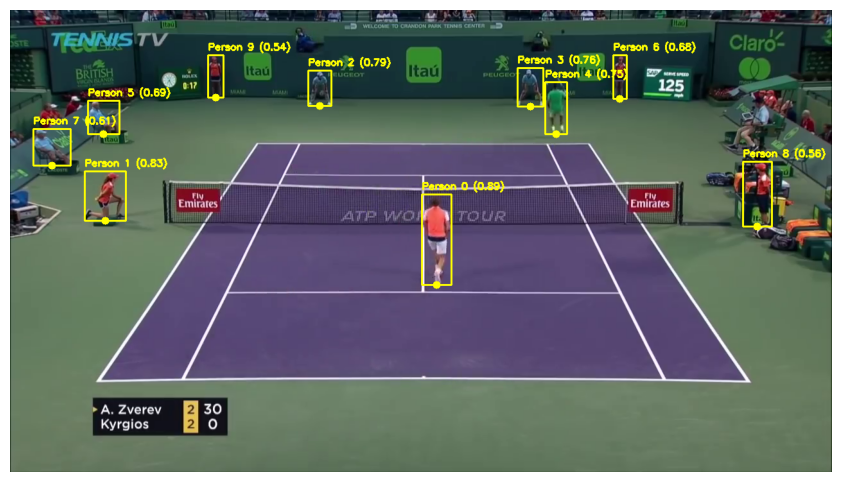

In [ ]:
img = "data/images/-0M6ixK7aIU_1250.png"
img = cv2.imread(img)

# se carga el modelo para la detección de personas
modelo = YOLO("yolov8x")

# se realizan las predicciones de YOLO
results = modelo(img, conf=0.4, classes=[0])

bboxes_players = []
for r in results:
    for bbox in r.boxes:
        x1, y1, x2, y2 = bbox.xyxy[0].cpu().numpy()
        conf = float(bbox.conf[0].cpu().numpy())

        bboxes_players.append({
            "bbox": [int(x1), int(y1), int(x2), int(y2)],
            "conf": conf
        })

print("Personas detectadas:", len(bboxes_players))
img_yolo = img.copy()

# para cada uno de las personas detectadas, se obtiene el centro inferior de la bbox
# que corresponde con una estimación de los pies
for i, p in enumerate(bboxes_players):
    x1, y1, x2, y2 = p["bbox"]
    centro = bbox_center_pies(p["bbox"])
    conf = p["conf"]

    cv2.rectangle(
        img_yolo,
        (x1, y1),
        (x2, y2),
        (0, 255, 255),  # amarillo para "personas detectadas"
        2
    )

    x0 ,y0  = centro

    cv2.circle(img_yolo, (x0, y0), 6, (0, 255, 255), -1)

    cv2.putText(
        img_yolo,
        f"Person {i} ({conf:.2f})",
        (x1, max(0, y1 - 8)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 255),
        2
    )

plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(img_yolo, cv2.COLOR_BGR2RGB))
plt.axis("off")

## **HOMOGRAFÍA INVERSA Y TRADUCCIÓN DE PUNTOS**

Ahora que ya tenemos claro como vamos a pasar los puntos desde la imagen original hasta un plano de referencia, vamos a pasar a realizar esta transformación para **crear un "minimapa" en el que se vea la pista de tenis y la posición relativa de los jugadores en ella**.

La **idea general** es construir un **“canvas” auxiliar que representa la pista en planta**, ampliarlo con un margen adicional para admitir posiciones fuera del rectángulo de juego, y finalmente integrarlo en la escena con transparencia para no ocultar el vídeo.

El flujo comienza creando una base del minimapa a partir de la imagen de referencia de la pista (`court_ref`). En lugar de usar únicamente el tamaño exacto de la pista, **se define un margen extendido (`extended_margin_px`) que amplía el área del minimapa** por todos los lados. Esto permite que, **si un jugador se proyecta ligeramente fuera de la pista** (por ejemplo, en pasillos laterales o detrás de la línea de fondo), su posición siga pudiendo representarse dentro del minimapa sin desaparecer ni quedar recortada. Esto lo añadimos porque **al principio solo lo calculábamos dentro de las líneas de la pista**, pero observamos que al final la **mayoria de tiempo los jugadores se encuentran fuera de ellas**. A continuación, esta área extendida se escala a un tamaño más pequeño para que pueda mostrarse como overlay sin ocupar demasiado espacio en la imagen.


In [ ]:
# función que construye la base de un minimapa de la pista con un margen extendido alrededor
# de la pista original, permitiendo representar posiciones fuera del rectángulo de juego

def build_minicourt_extended_base(court_ref, scale=0.3, extended_margin_px=80):
    if isinstance(court_ref, tuple):
        court_ref = court_ref[0]
    court_ref_img = court_ref

    # nos aseguramos que sea uint8
    if court_ref_img.dtype != np.uint8:
        court_ref_img = court_ref_img.astype(np.uint8)

    # dimensiones originales de la pista de ref
    h, w = court_ref_img.shape[:2]
    ext = int(extended_margin_px)

    # se calcula el tamaño del área extendida (coords court_ref)
    ext_w = w + 2 * ext
    ext_h = h + 2 * ext

    # dimensiones finales del minimapa tras aplicar el factor de escala
    mini_w = int(round(ext_w * scale))
    mini_h = int(round(ext_h * scale))

    # base negra (se usará como “fondo” a mezclar con la imagen real)
    base = np.zeros((mini_h, mini_w, 3), dtype=np.uint8)

    return base, ext, scale, court_ref_img


Una vez creada la base, **se dibuja la estructura de la pista dentro del minimapa**. Para ello, la pista de referencia se convierte a formato visual (BGR), se redimensiona y **se inserta en el canvas con un desplazamiento equivalente al margen extendido**. El resultado es un minimapa donde la pista aparece centrada y rodeada por un espacio adicional, **manteniendo siempre proporciones geométricas correctas**. Con esto, el minimapa queda listo, junto a un fondo sobre el que después se colocarán las posiciones de los jugadores.



In [ ]:
# función que dibuja las lineas de la pista dentro del minimap (sin margenes extra)
def draw_court_lines_on_minimap(minimap, court_ref_img, ext, scale, color=(255,255,255), thickness=1):
    # Convertir court_ref a BGR y escalarlo
    court_bgr = cv2.cvtColor(court_ref_img, cv2.COLOR_GRAY2BGR)

    # se escala la pista de referencia
    court_scaled = cv2.resize(
        court_bgr,
        (int(round(court_ref_img.shape[1] * scale)), int(round(court_ref_img.shape[0] * scale))),
        interpolation=cv2.INTER_AREA
    )

    # desplazamiento del origen de la pista dentro del minimapa extendido
    ox = int(round(ext * scale))
    oy = int(round(ext * scale))

    # se inserta la pista escalada dentro del minimapa extendido
    h_s, w_s = court_scaled.shape[:2]
    minimap[oy:oy+h_s, ox:ox+w_s] = court_scaled

    gray = cv2.cvtColor(minimap, cv2.COLOR_BGR2GRAY)
    mask = gray > 10
    minimap[mask] = color

    # marco del área extendida (sin pad)
    cv2.rectangle(minimap, (0, 0), (minimap.shape[1]-1, minimap.shape[0]-1), color, 2)

    return minimap

El siguiente paso es integrar el minimapa en la imagen original mediante transparencia. En vez de pegarlo de forma opaca, se mezcla con la región correspondiente de la imagen usando un factor `alpha_bg`, de modo que el minimapa se ve pero la escena real sigue siendo visible debajo.

Finalmente, las **posiciones de los jugadores**, **ya transformadas previamente al sistema de coordenadas de la pista mediante la homografía inversa**, se dibujan encima del minimapa ya mezclado, para que los puntos no queden difuminados por el blending. Para ello, **cada punto en coordenadas de pista se transforma a coordenadas del minimapa** usando el mismo factor de escala y el offset del margen extendido, y se **suma además el desplazamiento** donde el minimapa fue pegado en la imagen (`margin`). Se utiliza una **lógica** adicional para **diferenciar puntos dentro del área extendida** (verde) y **puntos claramente fuera incluso de ese margen** (rojo), que **se clipean** al borde extendido para mantener estabilidad visual.

En conjunto, este pipeline permite **pasar de coordenadas en imagen** (detección de jugadores) a **coordenadas del plano de la pista** (homografía inversa), y de ahí a una representación compacta y estable en un minimapa superpuesto.

In [ ]:
# función que convierte un punto en court a coordenadas (x, y) en la imagen final
def court_point_to_overlay_xy(pt, court_ref_shape, ext, scale, margin_xy):

    x, y = float(pt[0]), float(pt[1])
    x0, y0 = margin_xy # desplazamiento del minimapa en la imagen del final

    mx = int(round((x + ext) * scale)) + x0
    my = int(round((y + ext) * scale)) + y0
    return mx, my


# función que comprueba si un punto de la pista cae fuera del área extendida
def is_outside_extended_area(pt, court_shape, margin_px=80):
    x, y = float(pt[0]), float(pt[1])
    h, w = court_shape[:2]
    M = float(margin_px)
    return not (-M <= x < w + M and -M <= y < h + M)

# aplicando clamp, limita un punto para que permanezca dentro del rectángulo extendido.
# se utiliza para evitar que puntos fuera del área provoquen errores de dibujo.
def clamp_to_extended_rect(pt, court_shape, margin_px=80):
    x, y = float(pt[0]), float(pt[1])
    h, w = court_shape[:2]
    M = float(margin_px)
    x = max(-M, min(w - 1 + M, x))
    y = max(-M, min(h - 1 + M, y))
    return x, y

# función que dibuja las posiciones de los jugadores en el minimapa
def draw_players_on_overlay(
    overlay,
    court_ref_shape,
    player_positions_court,
    ext,
    scale,
    margin_xy=(40, 40),
    extended_margin_px=200,
    r=6
):
    h, w = court_ref_shape[:2]
    M = float(extended_margin_px)

    def outside_ext(pt):
        x, y = float(pt[0]), float(pt[1])
        return not (-M <= x < w + M and -M <= y < h + M)

    def clamp_ext(pt):
        x, y = float(pt[0]), float(pt[1])
        x = max(-M, min(w - 1 + M, x))
        y = max(-M, min(h - 1 + M, y))
        return x, y

    for pt in player_positions_court:
        if pt is None or not hasattr(pt, "__iter__") or len(pt) != 2:
            continue

        x, y = float(pt[0]), float(pt[1])

        if outside_ext((x, y)):
            x, y = clamp_ext((x, y))
            px, py = court_point_to_overlay_xy((x, y), court_ref_shape, ext, scale, margin_xy)
            cv2.circle(overlay, (px, py), r, (0, 0, 255), -1)  # rojo
        else:
            px, py = court_point_to_overlay_xy((x, y), court_ref_shape, ext, scale, margin_xy)
            cv2.circle(overlay, (px, py), r, (0, 255, 0), -1)  # verde

    return overlay



# función que pega el minimapa con fondo semitransparente sobre la imagen real
def paste_minimap_transparent(image, minimap, x0=40, y0=40, alpha_bg=0.55):
    overlay = image.copy()
    h, w = minimap.shape[:2]

    # se recorta si se sale del frame
    H_img, W_img = overlay.shape[:2]
    x1 = min(x0 + w, W_img)
    y1 = min(y0 + h, H_img)

    # se aplica roi
    roi = overlay[y0:y1, x0:x1]
    mini_crop = minimap[0:(y1-y0), 0:(x1-x0)]

    # Mezcla SOLO del fondo/estructura del minimapa con la imagen real
    blended = cv2.addWeighted(roi, 1 - alpha_bg, mini_crop, alpha_bg, 0)
    overlay[y0:y1, x0:x1] = blended

    return overlay


# función principal que recoge el resto de funcinoes para dibujar el minimapa final
def draw_minicourt_overlay(
    image,
    court_ref,
    player_positions_court,
    scale=0.3,
    margin=40,
    extended_margin_px=200,
    alpha_bg=0.55
):
    # 1) se construye el minimapa (base extendida)
    minimap, ext, sc, court_ref_img = build_minicourt_extended_base(
        court_ref=court_ref,
        scale=scale,
        extended_margin_px=extended_margin_px
    )

    # 2) se dibuja solo la pista en el minimapa (fondo + líneas)
    minimap = draw_court_lines_on_minimap(
        minimap=minimap,
        court_ref_img=court_ref_img,
        ext=ext,
        scale=sc,
        color=(255, 255, 255),
        thickness=1
    )

    # 3) se mezcla el minimapa con transparencia sobre la imagen real
    overlay = paste_minimap_transparent(
        image=image,
        minimap=minimap,
        x0=margin,
        y0=margin,
        alpha_bg=alpha_bg
    )

    # 4) se dibujan jugadores NÍTIDOS encima (sin blending)
    overlay = draw_players_on_overlay(
        overlay=overlay,
        court_ref_shape=court_ref_img.shape,
        player_positions_court=player_positions_court,
        ext=ext,
        scale=sc,
        margin_xy=(margin, margin),
        extended_margin_px=extended_margin_px,
        r=6
    )

    cv2.putText(
        overlay,
        "Court View",
        (margin, margin - 8),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.6,
        (255, 255, 255),
        2
    )

    return overlay

### **PRUEBAS EXPERIMENTALES DE VISUALIZACIÓN**

Una vez tenemos estas funciones, se realizan una serie de pruebas para visualizar las imagenes con el nuevo minimapa y validar la implementación.

Ahora, el pipeline va a probar con 5 imagenes aleatorias de nuestro dataset **desde la detección de jugadores hasta su representación en un minimapa de la pista**. Para cada iteración se selecciona una imagen aleatoria, se detectan personas con YOLO y se filtran las detecciones relevantes. En paralelo, la **imagen se calibra geométricamente detectando las líneas de la pista y calculando una homografía que relaciona la imagen con una pista de referencia en vista cenital**.

Con esta **homografía** se proyecta el contorno de la pista sobre la imagen original y **se transforman las posiciones de los jugadores** desde coordenadas de imagen a coordenadas del plano de la pista **mediante la homografía inversa**. A partir de ahí, se construye el minimapa y se dibujan las posiciones de los jugadores.



Processing random image: data/images/SzlcdL2kfBM_2200.png


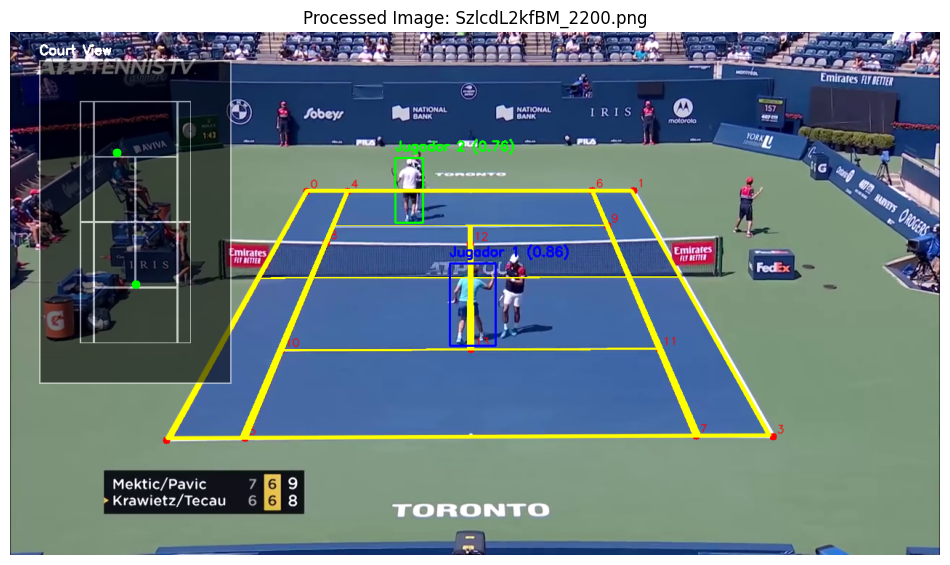

Processing random image: data/images/_Itl2z9fUQA_150.png


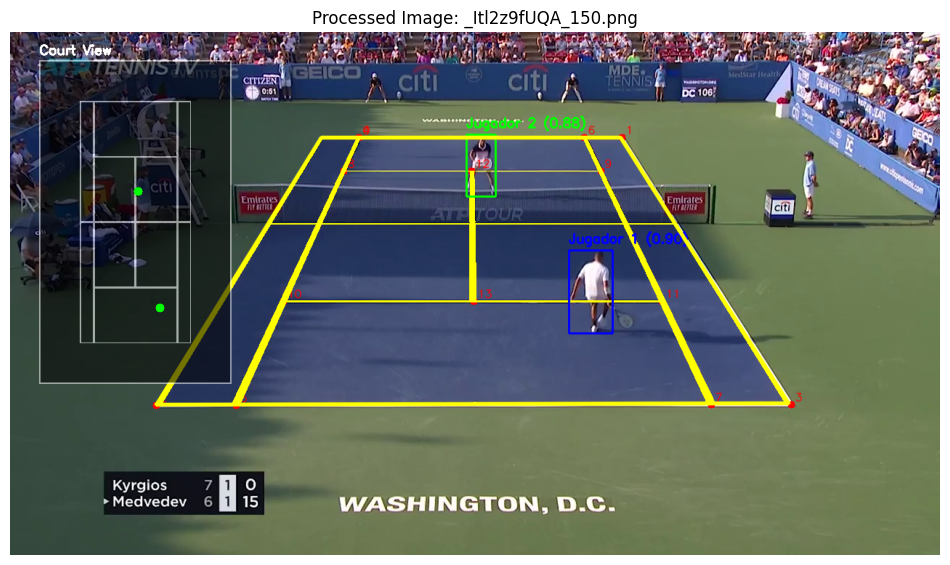

Processing random image: data/images/3xr9-4NUS7k_900.png


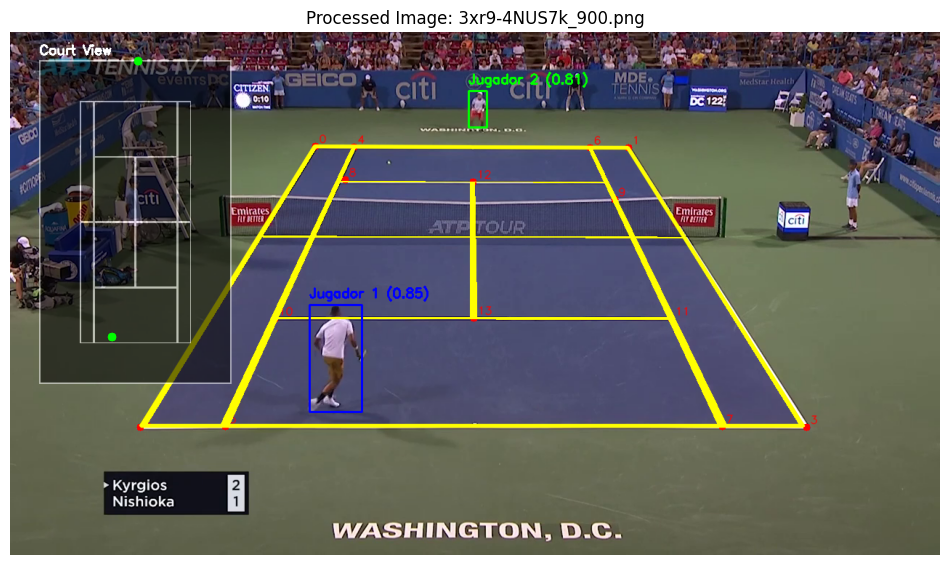

Processing random image: data/images/GsyM72flP5s_3100.png


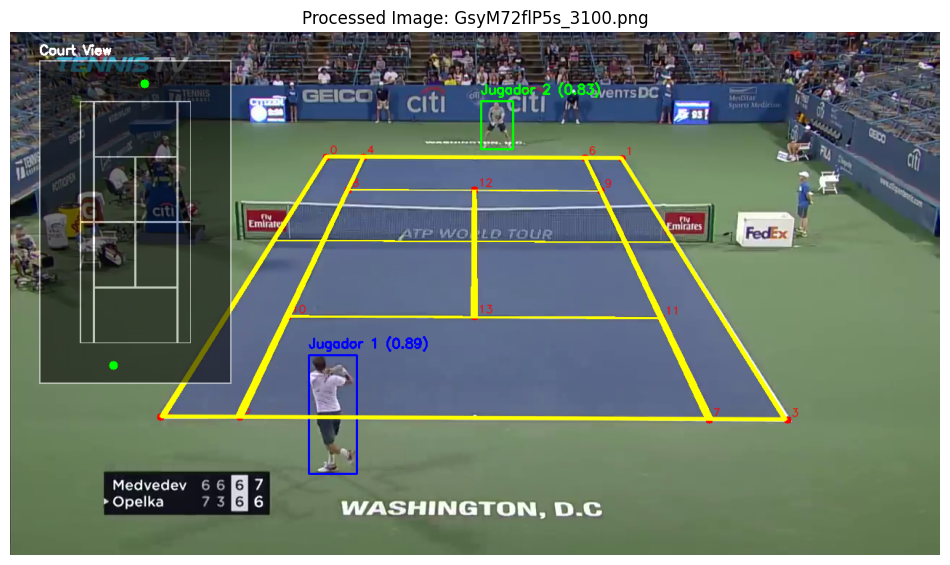

Processing random image: data/images/R4u1FHvdJaA_150.png


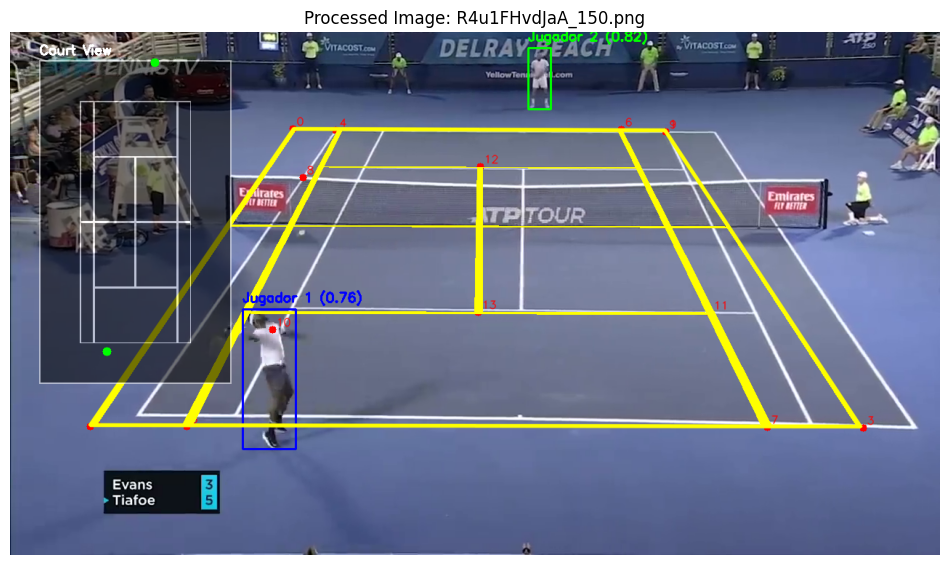

In [ ]:
detector = CourtLineDetector("drive/MyDrive/model_court.pth")

# se coge una lista de las imagenes
image_dir = "data/images"
all_image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]
court_ref, court_points  = create_tennis_court_reference()
modelo = YOLO("yolov8x")

for i in range(5):
  # se seleccionan imagenes aleatorias
  if all_image_files:
      random_image_path = random.choice(all_image_files)
      print(f"Processing random image: {random_image_path}")

      img = cv2.imread(random_image_path)

      # se obtienen las detecciones del modelo
      predicciones = modelo(img, conf=0.4, verbose=False , classes=[0])

      bboxes_players = []
      for r in predicciones:
          for bbox in r.boxes:
              x1, y1, x2, y2 = bbox.xyxy[0].cpu().numpy()
              conf = float(bbox.conf[0].cpu().numpy())


              bboxes_players.append({
                  "bbox": [int(x1), int(y1), int(x2), int(y2)],
                  "conf": conf
              })

      # calculo de los keypoints y la homografia
      _, court_keypoints, H  = process_court_image(random_image_path,detector)


      # se calcula el punto inferior que estima la posicion central de los pies
      for bb in bboxes_players:
          bb["x_c"], bb["y_c"] = bbox_center_pies(bb["bbox"])

      # keypoints virtuales
      kp_top_court, kp_bottom_court = kp_virtuales(court_points)

      # asignacion de jugadores
      top_player, bottom_player = asigna_jugadores_por_pies(
          bboxes_players, kp_top_court, kp_bottom_court, H
      )

      # paso de las coords a la pista
      if top_player is None or bottom_player is None:
          top = [-100, -100]
          bottom = [-100, -100]
      else:
          top = image_to_court(
              np.array([top_player["x_c"], top_player["y_c"]], dtype=np.float32),
              h_inv(H)
          )
          bottom = image_to_court(
              np.array([bottom_player["x_c"], bottom_player["y_c"]], dtype=np.float32),
              h_inv(H)
          )

      # --- dibujado ---

      # keypoints reales
      img_out = detector.draw_keypoints(img, court_keypoints.reshape(-1))

      # overlay de la pista
      img_out = overlay_court(image=img, court_ref=court_ref_img, H=H)

      # bounding boxes
      img_out = dibuja_bbox_jugadores(img_out, top_player, bottom_player)

      # borde de la pista
      border_pts = get_court_border(court_ref_img)
      border_img_pts = project_court_border(border_pts, H)
      img_out = draw_court_border(
          img_out, border_img_pts, color=(0, 255, 255), thickness=4
      )

      # mini-court view
      img_out = draw_minicourt_overlay(
          image=img_out,
          court_ref=court_ref_img,
          player_positions_court=[top, bottom],
          scale=0.28
      )

      if img_out is not None:
          # Display the processed image
          plt.figure(figsize=(12, 8))
          plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
          plt.title(f"Processed Image: {os.path.basename(random_image_path)}")
          plt.axis("off")
          plt.show()
      else:
          print(f"Failed to process image: {random_image_path}")
  else:
      print("No image files found in the directory.")

Como puede apreciarse en las imágenes, los resultados obtenidos son **coherentes y precisos**, ya que las **posiciones de los jugadores se proyectan correctamente** sobre el mapa de la pista de tenis.

Esto confirma que el **uso de la homografía inversa permite transformar de forma adecuada** las coordenadas de los jugadores desde el plano de la imagen original al plano de la pista, **preservando su posición relativa en el espacio de juego**.

Un aspecto clave del procedimiento ha sido la **elección del punto representativo** de cada jugador.  Si se utilizara, por ejemplo, el centro del cuerpo del jugador, la proyección al plano de la pista sería incorrecta, ya que ese punto no pertenece al plano de la homografía y se encuentra elevado respecto al suelo. Por tanto, la **selección adecuada del punto de contacto con el plano es determinante para garantizar la validez geométrica de la transformación y la correcta interpretación de las posiciones en el minimapa.**

## **MINI-COURT APLICADO A VIDEO**

Finalmente, se realiza el mismo procedimiento pero en un video, pudiendo así observar el movimiento de los jugadores en el minimapa.

In [ ]:
fps = 30
out_path = "players_tracking.mp4"
modelo = YOLO("yolov8x")

img_dir = "data/tracknet/Dataset/game2/Clip2"
img_paths = sorted(glob.glob(img_dir + "/*.jpg"))

first_img = cv2.imread(img_paths[0])
H_img, W_img = first_img.shape[:2]

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = cv2.VideoWriter(out_path, fourcc, fps, (W_img, H_img))

# referencia de la pista
court_ref_img, court_points = create_tennis_court_reference()

# se inicializa el detector con los pesos para los kps
detector = CourtLineDetector("drive/MyDrive/model_court.pth")

current_court_keypoints = None
H = None  # homografía actual (se actualiza cada N frames)

for frame_idx, img_path in enumerate(img_paths):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # cada 7 frames se actualiza la homografica calculada y los kps
    if frame_idx % 7 == 0 or current_court_keypoints is None or H is None:
        try:
            _, court_keypoints, H = process_court_image(img_path, detector)
            current_court_keypoints = court_keypoints
        except Exception as e:
            print(f"Error court detection frame {frame_idx}: {e}")
            current_court_keypoints = None
            H = None

    if current_court_keypoints is None or H is None:
        video_writer.write(img)
        continue

    # yolo
    predicciones = modelo(img_rgb, conf=0.4, classes=[0], verbose=False)

    bboxes_players = []
    for r in predicciones:
        for bbox in r.boxes:
            x1, y1, x2, y2 = bbox.xyxy[0].cpu().numpy()
            conf = float(bbox.conf[0].cpu().numpy())

            bboxes_players.append({
                "bbox": [int(x1), int(y1), int(x2), int(y2)],
                "conf": conf
            })

    if len(bboxes_players) < 2:
        # aun así podemos dibujar pista + kp y escribir
        img_out = overlay_court(image=img, court_ref=court_ref_img, H=H)
        img_out = detector.draw_keypoints(img_out, current_court_keypoints.reshape(-1))
        video_writer.write(img_out)
        continue

    # pies
    for bb in bboxes_players:
        bb["x_c"], bb["y_c"] = bbox_center_pies(bb["bbox"])

    # keypoints virtuales
    kp_top_court, kp_bottom_court = kp_virtuales(court_points)

    # asignación de jugadores
    top_player, bottom_player = asigna_jugadores_por_pies(
        bboxes_players, kp_top_court, kp_bottom_court, H
    )

    # coordenadas a pista
    if top_player is None or bottom_player is None:
        top = [-100, -100]
        bottom = [-100, -100]
    else:
        top = image_to_court(np.array([top_player["x_c"], top_player["y_c"]], dtype=np.float32), h_inv(H))
        bottom = image_to_court(np.array([bottom_player["x_c"], bottom_player["y_c"]], dtype=np.float32), h_inv(H))

    # --- dibujado ---
    img_out = img.copy()

    # overlay pista
    img_out = overlay_court(image=img_out, court_ref=court_ref_img, H=H)

    # bbox jugadores
    img_out = dibuja_bbox_jugadores(img_out, top_player, bottom_player)

    # keypoints reales detectados
    img_out = detector.draw_keypoints(img_out, current_court_keypoints.reshape(-1))

    # borde de pista
    border_pts = get_court_border(court_ref_img)
    border_img_pts = project_court_border(border_pts, H)
    img_out = draw_court_border(img_out, border_img_pts, color=(0, 255, 255), thickness=4)

    # minimapa
    img_out = draw_minicourt_overlay(
        image=img_out,
        court_ref=court_ref_img,
        player_positions_court=[top, bottom],
        scale=0.28
    )

    video_writer.write(img_out)

video_writer.release()
print("Vídeo generado:", out_path)


Vídeo generado: players_tracking.mp4


In [ ]:
!ffmpeg -y -i players_tracking.mp4 -vcodec libx264 -pix_fmt yuv420p players_tracking_fixed.mp4 > /dev/null 2>&1


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
from IPython.display import Video, display
display(Video("players_tracking_fixed.mp4", embed=True))
